In [22]:
%reset -f

In [23]:
# Import modules for building a neural operator model
import numpy as np
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

# Import specialized neural operator model tools
from neuralop.models import FNO, FNO2d, TFNO, TFNO2d

# For creating datasets and data loaders for training and evaluation
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler

# For plotting and visualization
import matplotlib.pyplot as plt

# Optional: Use tqdm for progress bars during training and evaluation
from tqdm import tqdm

import NO_utils_multiple
import NO_utils
import os
import random
import gc
gc.collect()

0

In [24]:
#Set the device for the neural operator model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device:', device)
print("Using PyTorch version:", torch.__version__)

Using Device: cuda
Using PyTorch version: 2.4.1+cu118


## Load and visualize data

data\set 3
Data loaded in 517.48 seconds.
Spatial waves shape: (600, 325, 32, 32)
n_designs: 600, n_panes: 3, design_res: 32, d_design: 2, dispersion_bands: 6, rng_seed_offset: [[1200.]]
EIGENVALUE_DATA shape: (600, 325, 6)
EIGENVECTOR_DATA shape: (600, 325, 6, 2048)
EIGENVECTOR_DATA_x shape: (600, 325, 6, 32, 32)
EIGENVECTOR_DATA_y shape: (600, 325, 6, 32, 32)
WAVEVECTOR_DATA shape: (600, 325, 2)
WAVEFORM_DATA shape: (600, 325, 32, 32)
designs shape: (600, 3, 32, 32)
design_params shape: (1, 6)
const shape: {'E_max': (1, 1), 'E_min': (1, 1), 'N_eig': (1, 1), 'N_ele': (1, 1), 'N_pix': (1, 1), 'N_wv': (2, 1), 'a': (1, 1), 'design': (3, 32, 32), 'design_scale': (6, 1), 'isSaveEigenvectors': (1, 1), 'isUseGPU': (1, 1), 'isUseImprovement': (1, 1), 'isUseParallel': (1, 1), 'isUseSecondImprovement': (1, 1), 'poisson_max': (1, 1), 'poisson_min': (1, 1), 'rho_max': (1, 1), 'rho_min': (1, 1), 'sigma_eig': (1, 1), 'symmetry_type': (4, 1), 't': (1, 1), 'wavevectors': (2, 325)}


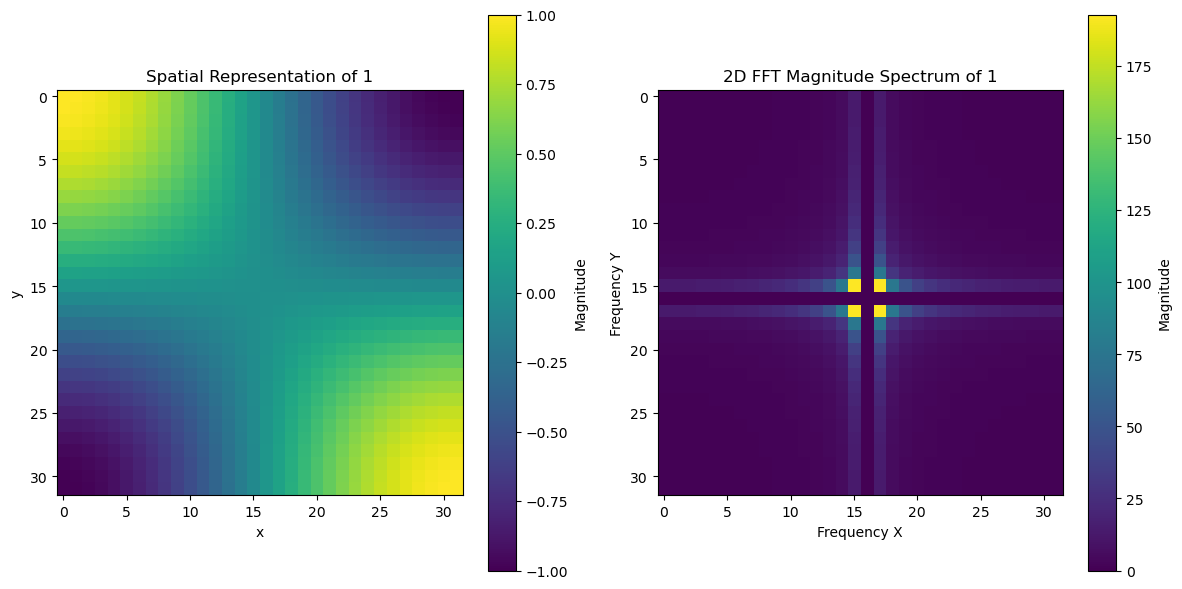

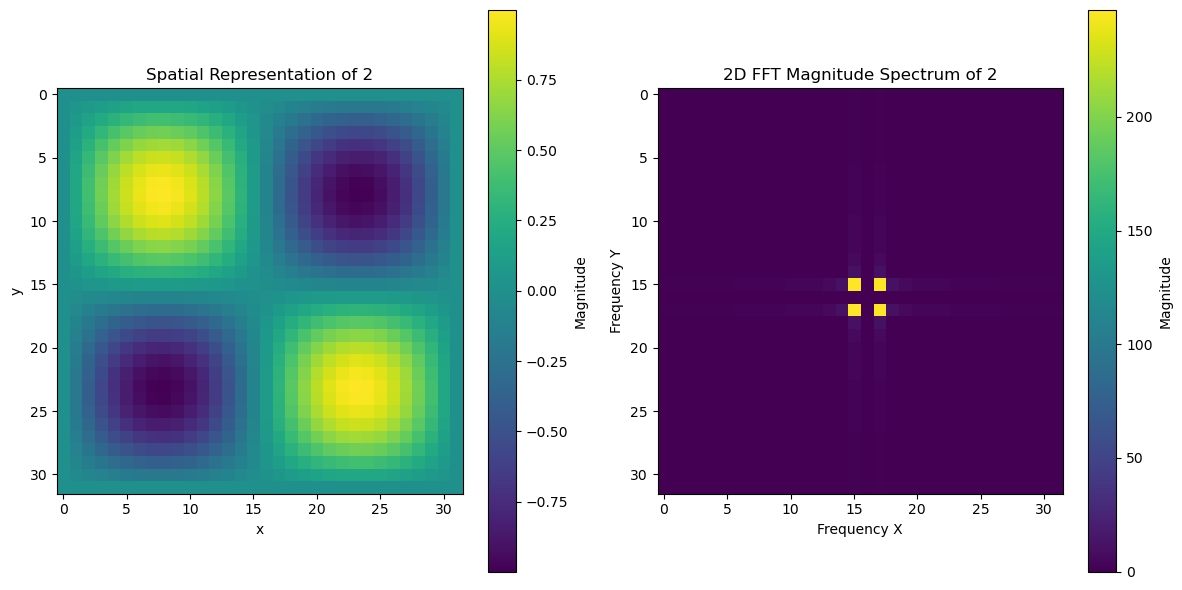

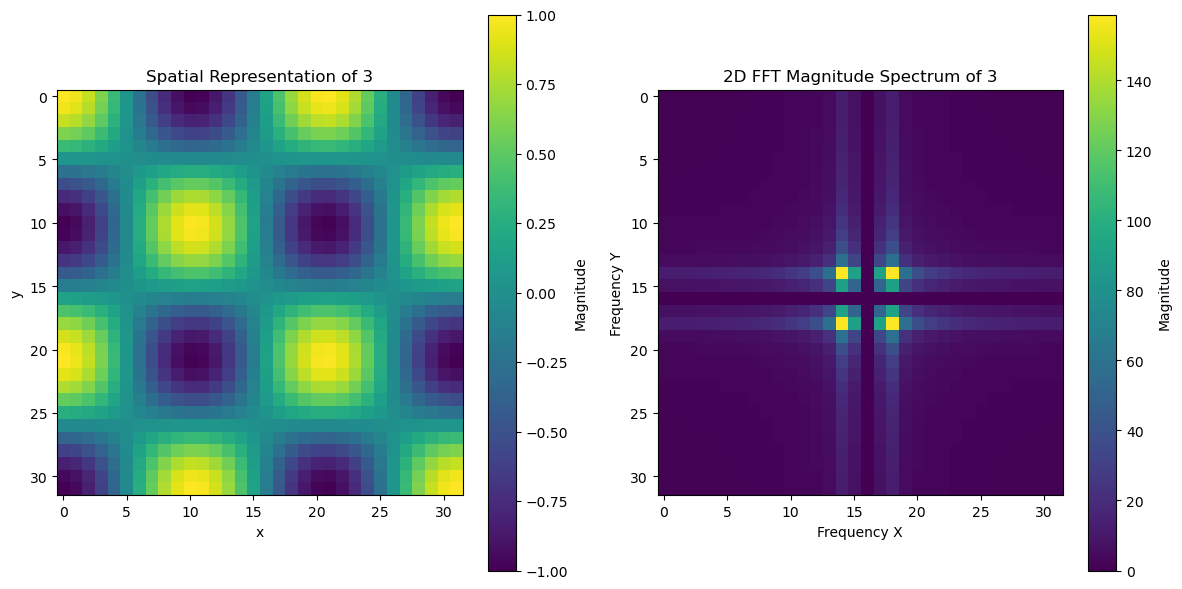

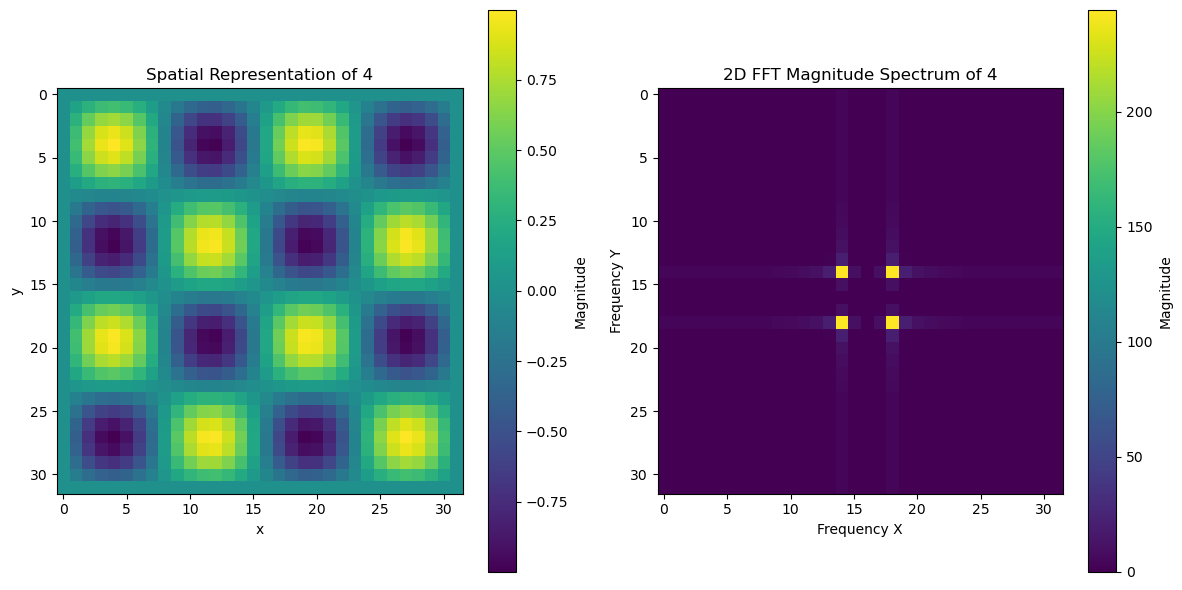

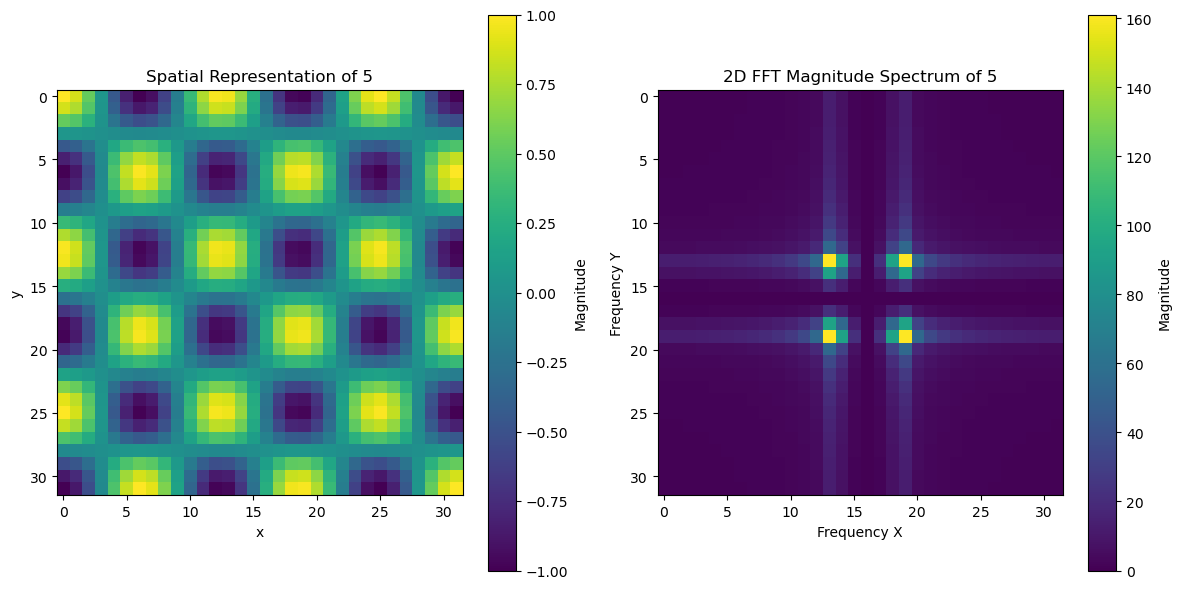

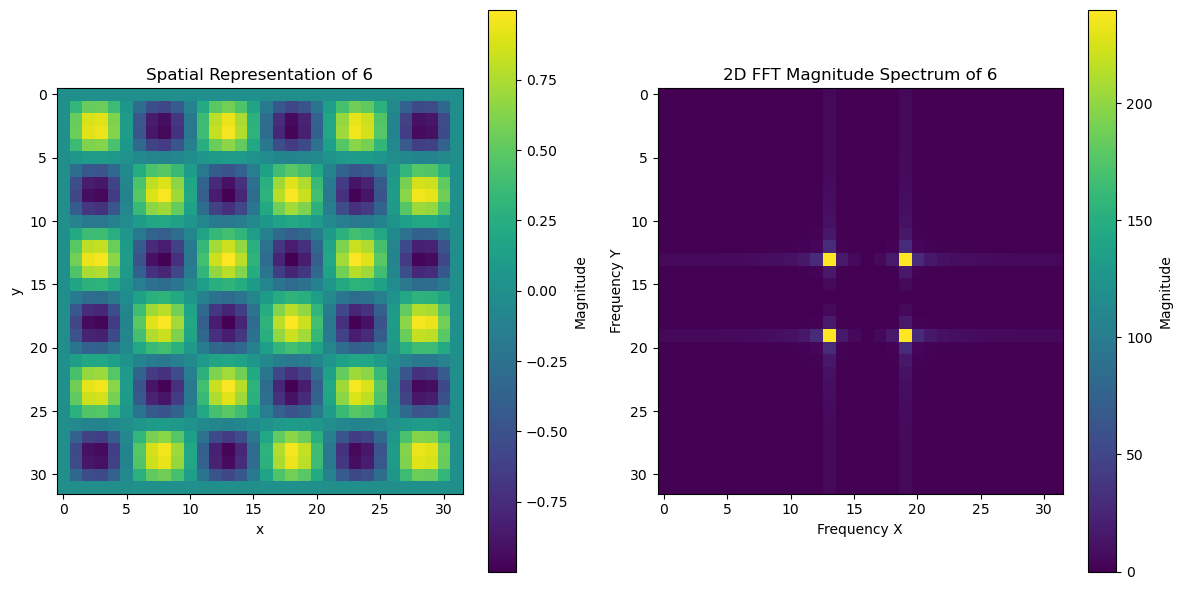

In [25]:
# Load and extract data
# datafolder_name = ["OUTPUT", "discrete_symmetric_p32_n800_rs400"]
datafolder_name = ["data", "set 3"]
data_path = os.path.join(*datafolder_name)
print(data_path)

designs, design_params, n_designs, n_panes, design_res, WAVEVECTOR_DATA, WAVEFORM_DATA, n_dim, n_wavevectors, EIGENVALUE_DATA, n_bands, EIGENVECTOR_DATA_x, EIGENVECTOR_DATA_y, const, N_struct, imag_tol, rng_seed_offset = NO_utils.extract_data(data_path)

#Convert all bands to spatial domain
bands = np.arange(1, n_bands + 1)
bands_fft = np.zeros((n_bands, design_res, design_res))
for i, band in enumerate(bands):
    bands_fft[i], _ = NO_utils_multiple.const_to_spatial(band, design_res, plot_result=True, scaling_factor=1.0)

#Take unique subset of waveforms    
waveforms = WAVEFORM_DATA[0]

In [26]:
# Print the max and min values of all the arrays with a size of 400 in its first dimension.

print(f'Max value of designs: {np.max(designs)}')
print(f'Min value of designs: {np.min(designs)}')
print(f'Max value of WAVEFORM_DATA: {np.max(WAVEFORM_DATA)}')
print(f'Min value of WAVEFORM_DATA: {np.min(WAVEFORM_DATA)}')
print(f'Max value of WAVEVECTOR_DATA_x: {np.max(EIGENVECTOR_DATA_x)}')
print(f'Min value of WAVEVECTOR_DATA_x: {np.min(EIGENVECTOR_DATA_x)}')
print(f'Max value of WAVEVECTOR_DATA_y: {np.max(EIGENVECTOR_DATA_y)}')
print(f'Min value of WAVEVECTOR_DATA_y: {np.min(EIGENVECTOR_DATA_y)}')

# Flatten the arrays and plot a separate histogram showing the distribution of values for each array with a size of 400 in its first dimension. Drop any imaginary components for the eigenvectors.

# Flatten the arrays
designs_flat = designs.flatten()
WAVEFORM_DATA_flat = WAVEFORM_DATA.flatten()
EIGENVECTOR_DATA_x_flat = EIGENVECTOR_DATA_x.flatten()
EIGENVECTOR_DATA_y_flat = EIGENVECTOR_DATA_y.flatten()

# Take the symlog of the flattened arrays. Take the real value for complex valued arrays.
designs_flat_symlog = np.sign(designs_flat) * np.log10(np.abs(designs_flat) + 1)
WAVEFORM_DATA_flat_symlog = np.sign(WAVEFORM_DATA_flat) * np.log10(np.abs(WAVEFORM_DATA_flat) + 1)
EIGENVECTOR_DATA_x_flat_symlog = np.sign(EIGENVECTOR_DATA_x_flat.real) * np.log10(np.abs(EIGENVECTOR_DATA_x_flat.real) + 1)
EIGENVECTOR_DATA_y_flat_symlog = np.sign(EIGENVECTOR_DATA_y_flat.real) * np.log10(np.abs(EIGENVECTOR_DATA_y_flat.real) + 1)

Max value of designs: 1.0
Min value of designs: 0.0
Max value of WAVEFORM_DATA: 1.0
Min value of WAVEFORM_DATA: -0.9999995318233016
Max value of WAVEVECTOR_DATA_x: (0.65625+0j)
Min value of WAVEVECTOR_DATA_x: (-0.591796875+0.04949951171875j)
Max value of WAVEVECTOR_DATA_y: (0.62255859375+0j)
Min value of WAVEVECTOR_DATA_y: (-0.62255859375+0j)


## Model architecture & training

In [27]:
def symlog_transform(x, linthresh=1):
    return np.sign(x) * np.log10(np.abs(x) + linthresh)

def symlog_inverse_transform(y, linthresh=1):
    return np.sign(y) * (10**np.abs(y) - linthresh)

# Function to fit and transform with StandardScaler, with optional symlog transformation
def standardize_array(array, symlog=False):
    scaler = StandardScaler()
    original_shape = array.shape
    array_flat = array.reshape(-1, 1)  # Flatten the array to 2D

    if symlog:
        array_flat = symlog_transform(array_flat)

    array_standardized = scaler.fit_transform(array_flat).reshape(original_shape)
    mean = scaler.mean_[0]
    scale = scaler.scale_[0]

    return array_standardized, mean, scale, symlog

In [28]:
# Standardizing EIGENVALUE_DATA and casting to float16
EIGENVALUE_DATA_standardized, eigenvalue_mean, eigenvalue_scale, _ = standardize_array(EIGENVALUE_DATA)
EIGENVALUE_DATA_standardized = EIGENVALUE_DATA_standardized.astype(np.float16)

# Standardizing EIGENVECTOR_DATA_x (real and imaginary parts separately) and casting to float16
EIGENVECTOR_x_r = EIGENVECTOR_DATA_x.real.astype(np.float16)
EIGENVECTOR_x_i = EIGENVECTOR_DATA_x.imag.astype(np.float16)

EIGENVECTOR_x_r_standardized, eigvector_x_r_mean, eigvector_x_r_scale, _ = standardize_array(EIGENVECTOR_x_r)
EIGENVECTOR_x_r_standardized = EIGENVECTOR_x_r_standardized.astype(np.float16)

EIGENVECTOR_x_i_standardized, eigvector_x_i_mean, eigvector_x_i_scale, _ = standardize_array(EIGENVECTOR_x_i)
EIGENVECTOR_x_i_standardized = EIGENVECTOR_x_i_standardized.astype(np.float16)

# Standardizing EIGENVECTOR_DATA_y (real and imaginary parts separately) and casting to float16
EIGENVECTOR_y_r = EIGENVECTOR_DATA_y.real.astype(np.float16)
EIGENVECTOR_y_i = EIGENVECTOR_DATA_y.imag.astype(np.float16)

EIGENVECTOR_y_r_standardized, eigvector_y_r_mean, eigvector_y_r_scale, _ = standardize_array(EIGENVECTOR_y_r)
EIGENVECTOR_y_r_standardized = EIGENVECTOR_y_r_standardized.astype(np.float16)

EIGENVECTOR_y_i_standardized, eigvector_y_i_mean, eigvector_y_i_scale, _ = standardize_array(EIGENVECTOR_y_i)
EIGENVECTOR_y_i_standardized = EIGENVECTOR_y_i_standardized.astype(np.float16)

# Standardizing WAVEVECTOR_DATA and casting to float16
WAVEVECTOR_DATA_standardized, wavevector_mean, wavevector_scale, _ = standardize_array(WAVEVECTOR_DATA)
WAVEVECTOR_DATA_standardized = WAVEVECTOR_DATA_standardized.astype(np.float16)

del EIGENVECTOR_DATA_x, EIGENVECTOR_DATA_y


In [29]:
# Print shapes and data types of arrays to verify
print("EIGENVALUE_DATA_standardized shape:", EIGENVALUE_DATA_standardized.shape, "dtype:", EIGENVALUE_DATA_standardized.dtype)
print("EIGENVECTOR_x_r_standardized shape:", EIGENVECTOR_x_r_standardized.shape, "dtype:", EIGENVECTOR_x_r_standardized.dtype)
print("EIGENVECTOR_x_i_standardized shape:", EIGENVECTOR_x_i_standardized.shape, "dtype:", EIGENVECTOR_x_i_standardized.dtype)
print("EIGENVECTOR_y_r_standardized shape:", EIGENVECTOR_y_r_standardized.shape, "dtype:", EIGENVECTOR_y_r_standardized.dtype)
print("EIGENVECTOR_y_i_standardized shape:", EIGENVECTOR_y_i_standardized.shape, "dtype:", EIGENVECTOR_y_i_standardized.dtype)
print("WAVEVECTOR_DATA_standardized shape:", WAVEVECTOR_DATA_standardized.shape, "dtype:", WAVEVECTOR_DATA_standardized.dtype)
print('\n')

# Print the mean and scale values for each standardized array
print("Eigenvalue mean, scale:", eigenvalue_mean, eigenvalue_scale)
print("Eigenvector x real mean, scale:", eigvector_x_r_mean, eigvector_x_r_scale)
print("Eigenvector x imag mean, scale:", eigvector_x_i_mean, eigvector_x_i_scale)
print("Eigenvector y real mean, scale:", eigvector_y_r_mean, eigvector_y_r_scale)
print("Eigenvector y imag mean, scale:", eigvector_y_i_mean, eigvector_y_i_scale)
print("Wavevector mean, scale:", wavevector_mean, wavevector_scale)
print('\n')

# Print the full range and data types of values for each standardized array
print("Eigenvalue range:", np.min(EIGENVALUE_DATA_standardized), np.max(EIGENVALUE_DATA_standardized), "dtype:", EIGENVALUE_DATA_standardized.dtype)
print("Eigenvector x real range:", np.min(EIGENVECTOR_x_r_standardized), np.max(EIGENVECTOR_x_r_standardized), "dtype:", EIGENVECTOR_x_r_standardized.dtype)
print("Eigenvector x imag range:", np.min(EIGENVECTOR_x_i_standardized), np.max(EIGENVECTOR_x_i_standardized), "dtype:", EIGENVECTOR_x_i_standardized.dtype)
print("Eigenvector y real range:", np.min(EIGENVECTOR_y_r_standardized), np.max(EIGENVECTOR_y_r_standardized), "dtype:", EIGENVECTOR_y_r_standardized.dtype)
print("Eigenvector y imag range:", np.min(EIGENVECTOR_y_i_standardized), np.max(EIGENVECTOR_y_i_standardized), "dtype:", EIGENVECTOR_y_i_standardized.dtype)
print("Wavevector range:", np.min(WAVEVECTOR_DATA_standardized), np.max(WAVEVECTOR_DATA_standardized), "dtype:", WAVEVECTOR_DATA_standardized.dtype)

EIGENVALUE_DATA_standardized shape: (600, 325, 6) dtype: float16
EIGENVECTOR_x_r_standardized shape: (600, 325, 6, 32, 32) dtype: float16
EIGENVECTOR_x_i_standardized shape: (600, 325, 6, 32, 32) dtype: float16
EIGENVECTOR_y_r_standardized shape: (600, 325, 6, 32, 32) dtype: float16
EIGENVECTOR_y_i_standardized shape: (600, 325, 6, 32, 32) dtype: float16
WAVEVECTOR_DATA_standardized shape: (600, 325, 2) dtype: float16


Eigenvalue mean, scale: 1871.8432521906445 804.8099957268108
Eigenvector x real mean, scale: 0.0017915413533391641 0.016245354192668857
Eigenvector x imag mean, scale: -0.000866146585611929 0.01486849669175012
Eigenvector y real mean, scale: -0.0006238377938198789 0.01599053432652891
Eigenvector y imag mean, scale: -0.0008250227118797529 0.015193810446393818
Wavevector mean, scale: 0.7851938100961539 1.6961967499598463


Eigenvalue range: -2.326 2.57 dtype: float16
Eigenvector x real range: -36.56 40.28 dtype: float16
Eigenvector x imag range: -39.38 39.88 dtype: float1

In [30]:
# Prepare input and output data
num_samples = n_designs * n_wavevectors * n_bands
input_data = torch.zeros((num_samples, 3, design_res, design_res))
output_data = torch.zeros((num_samples, 4, design_res, design_res))

sample_idx = 0
for i in range(n_designs):
    for j in range(n_wavevectors):
        for k in range(n_bands):

            input_data[sample_idx, 0] = torch.from_numpy(designs[i, 0])
            input_data[sample_idx, 1] = torch.from_numpy(waveforms[j])
            input_data[sample_idx, 2] = torch.from_numpy(bands_fft[k])

            output_data[sample_idx, 0] = torch.from_numpy(EIGENVECTOR_x_r_standardized[i, j, k])
            output_data[sample_idx, 1] = torch.from_numpy(EIGENVECTOR_x_i_standardized[i, j, k])
            output_data[sample_idx, 2] = torch.from_numpy(EIGENVECTOR_y_r_standardized[i, j, k])
            output_data[sample_idx, 3] = torch.from_numpy(EIGENVECTOR_y_i_standardized[i, j, k])

            sample_idx += 1

# Create dataset
dataset = TensorDataset(input_data, output_data)

# Split dataset into train, test, and validation sets
train_size = int(0.75 * len(dataset))
test_size = int(0.2 * len(dataset))
val_size = len(dataset) - train_size - test_size

# train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])

train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])
batch_size = 256  # Adjust this according to your system's memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 877500
Test dataset size: 234000
Validation dataset size: 58500


In [31]:
# Print the shapes of the input and output data, train, test, and validation sets
print('Input data shape:', input_data.shape)
print('Output data shape:', output_data.shape)
print('Train data size:', len(train_dataset))
print('Test data size:', len(test_dataset))
print('Validation data size:', len(val_dataset))

# Inspect the first batch of data
for sample in train_loader:
    print('Batch shape:', sample[0].shape, sample[1].shape)
    #print(sample)
    break

Input data shape: torch.Size([1170000, 3, 32, 32])
Output data shape: torch.Size([1170000, 4, 32, 32])
Train data size: 877500
Test data size: 234000
Validation data size: 58500
Batch shape: torch.Size([256, 3, 32, 32]) torch.Size([256, 4, 32, 32])


In [32]:
class FourierNeuralOperator(nn.Module):
    def __init__(self, modes_height, modes_width, in_channels=3, out_channels=4, hidden=32):
        super(FourierNeuralOperator, self).__init__()
        self.modes_height = modes_height  # Number of Fourier modes in height dimension
        self.modes_width = modes_width  # Number of Fourier modes in width dimension
        self.hidden = hidden  # Width of the hidden channels
        self.in_channels = in_channels  # Number of input channels
        self.out_channels = out_channels  # Number of output channels

        # FNO2d layer
        self.fno = FNO2d(in_channels=self.in_channels, out_channels=self.out_channels, n_modes_height=self.modes_height, n_modes_width=self.modes_width, hidden_channels=self.hidden, num_layers=4)

    def forward(self, x):
        # Apply the FNO2d layer
        x = self.fno(x)
        return x

In [43]:
def train_one_epoch(model, loader, criterion, optimizer, device, epoch, report_freq=100, save_after_batch=False, save_path=None):
    model.train()
    running_loss = 0.0
    total_batches = len(loader)
    progress_bar = tqdm(enumerate(loader), total=total_batches, desc=f"Epoch {epoch + 1}")

    for batch_idx, (inputs, targets) in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets).mean()  # Ensure the loss is a scalar
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Print progress for each batch
        if (batch_idx + 1) % report_freq == 0 or (batch_idx + 1) == total_batches:
            progress_bar.set_postfix(batch_loss=loss.item())

        # Save model weights after each batch if the flag is set
        if save_after_batch and save_path:
            save_model(model, save_path)

    epoch_loss = running_loss / len(loader.dataset)

    # Save model weights after each epoch if the flag is not set
    if not save_after_batch and save_path:
        save_model(model, save_path)

    return epoch_loss

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc="Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets).mean()  # Ensure the loss is a scalar
            running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

# Function to save the model weights
def save_model(model, file_path):
    torch.save(model.state_dict(), file_path)

# Function to load the model weights
def load_model(model, file_path):
    model.load_state_dict(torch.load(file_path))

In [44]:
def plot_sample(data, title, labels, shared_colorbar=False):
    # Automatically select layout based on the number of data arrays
    num_arrays = data.shape[0]
    if num_arrays == 3:
        layout = (1, 3)
    elif num_arrays == 4:
        layout = (2, 2)
    else:
        raise ValueError("Data input must have 3 or 4 arrays for plotting.")

    fig, axes = plt.subplots(*layout, figsize=(10, 10))

    if shared_colorbar:
        # Compute global min and max for the shared colorbar
        vmin = np.min(data.cpu().numpy())
        vmax = np.max(data.cpu().numpy())

    for ax, (idx, label) in zip(axes.flatten(), labels):
        im = ax.imshow(data[idx, :, :].cpu(), cmap='viridis', vmin=vmin if shared_colorbar else None, vmax=vmax if shared_colorbar else None)
        ax.set_title(label)
        if not shared_colorbar:
            fig.colorbar(im, ax=ax)

    if shared_colorbar:
        # Add a single colorbar to the right of the plot
        cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)
        cbar.ax.set_ylabel('Color scale')

    plt.suptitle(title)
    plt.show()

def plot_inputs(data, title, labels, shared_colorbar=False):
    plot_sample(data, title, labels, shared_colorbar)

def plot_predictions_and_targets(inputs, outputs, targets):
    input_labels = [(0, 'geometry'), (1, 'waveform'), (2, 'band')]
    plot_sample(inputs, 'Inputs', input_labels, shared_colorbar=True)

    prediction_labels = [(0, 'eigenvector_x_real'), (1, 'eigenvector_x_imag'), (2, 'eigenvector_y_real'), (3, 'eigenvector_y_imag')]
    plot_sample(outputs, "Model Predictions", prediction_labels, shared_colorbar=True)

    target_labels = [(0, 'eigenvector_x_real'), (1, 'eigenvector_x_imag'), (2, 'eigenvector_y_real'), (3, 'eigenvector_y_imag')]
    plot_sample(targets, "Target Values", target_labels, shared_colorbar=True)

In [42]:
class PercentageErrorLoss(nn.Module):
    def __init__(self, epsilon=1e-10):
        super(PercentageErrorLoss, self).__init__()
        self.epsilon = epsilon

    def forward(self, pred, target):
        # Compute the absolute difference between prediction and target
        abs_error = torch.abs(pred - target)

        # Compute percentage error
        percentage_error = abs_error / (torch.abs(target) + self.epsilon)

        # Sum the percentage errors
        return torch.mean(percentage_error)

In [51]:
model = FourierNeuralOperator(modes_height=design_res, modes_width=design_res, in_channels=3, out_channels=4, hidden=32).to(device)

# Define the loss function
# criterion = nn.MSELoss()  # Mean Squared Error loss
criterion = nn.SmoothL1Loss()
# criterion = PercentageErrorLoss()

# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.1, weight_decay=0.01)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [52]:
# Parameters for saving/loading model weights
save_path = './model_weights.pth'
# save_path = '.trained models/cont/model_weights_e300.pth'
load_path = '.trained models/cont/model_weights_e300.pth'
load_existing_model = True  # Set to True if you want to load an existing model

# Load the model weights if a valid file path is provided and the flag is set
if load_existing_model and os.path.isfile(load_path):
    load_model(model, load_path)
    print(f"Loaded model weights from {load_path}")

# Lists to store losses for plotting
train_losses = []
val_losses = []

Evaluating: 100%|██████████| 229/229 [00:27<00:00,  8.24it/s]


Epoch 1/10, Training Loss: 3.6468, Validation Loss: 0.21867213


Evaluating: 100%|██████████| 229/229 [00:23<00:00,  9.73it/s]


Epoch 2/10, Training Loss: 0.1947, Validation Loss: 0.18467109


Evaluating: 100%|██████████| 229/229 [00:12<00:00, 19.00it/s]


Epoch 3/10, Training Loss: 2.0909, Validation Loss: 0.36387794


Evaluating: 100%|██████████| 229/229 [00:16<00:00, 13.54it/s]


Epoch 4/10, Training Loss: 0.2667, Validation Loss: 0.20488273


Evaluating: 100%|██████████| 229/229 [00:21<00:00, 10.89it/s]


Epoch 5/10, Training Loss: 0.1835, Validation Loss: 0.18368980


Evaluating: 100%|██████████| 229/229 [00:24<00:00,  9.44it/s]


Epoch 6/10, Training Loss: 109.9067, Validation Loss: 0.36315571


Evaluating: 100%|██████████| 229/229 [00:21<00:00, 10.57it/s]


Epoch 7/10, Training Loss: 0.3432, Validation Loss: 0.27183957


Evaluating: 100%|██████████| 229/229 [00:13<00:00, 17.04it/s]


Epoch 8/10, Training Loss: 0.2476, Validation Loss: 0.22610608


Evaluating: 100%|██████████| 229/229 [00:11<00:00, 19.94it/s]


Epoch 9/10, Training Loss: 0.2090, Validation Loss: 0.20951069


Evaluating: 100%|██████████| 229/229 [00:26<00:00,  8.52it/s]


Epoch 10/10, Training Loss: 0.1924, Validation Loss: 0.18721366


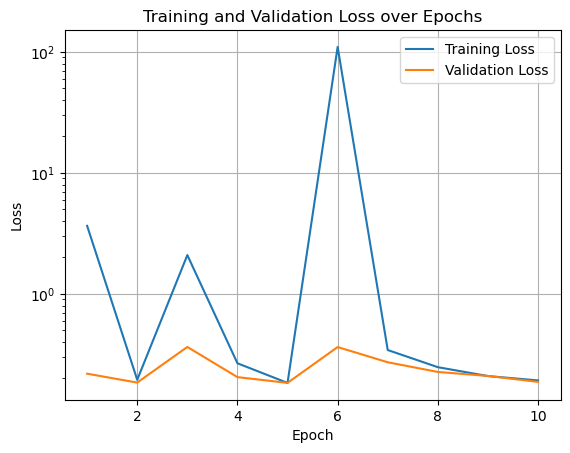

In [53]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, report_freq=128, save_after_batch=False, save_path=save_path)
    
    val_loss = evaluate(model, val_loader, criterion, device)

    # Print progress for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.8f}")

    # Save losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Step the scheduler
    scheduler.step(val_loss)

# Plot the losses
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.yscale('log')  # Set the y-axis to log scale
plt.savefig('loss_plot.png')  # Save the plot as a PNG file
plt.show()  # Display the plot

In [54]:
# Save the model weights at the end of training
# save_model(model, save_path)
save_path_posttraining = f'./model_weights_rel_loss_e{len(train_losses)}.pth'
save_model(model, save_path_posttraining)
print(f"Saved model weights to {save_path_posttraining}")

Saved model weights to ./model_weights_rel_loss_e10.pth


In [55]:
# Load older model weights
# load_path = './model_weights_e101.pth'
# load_model(model, load_path)

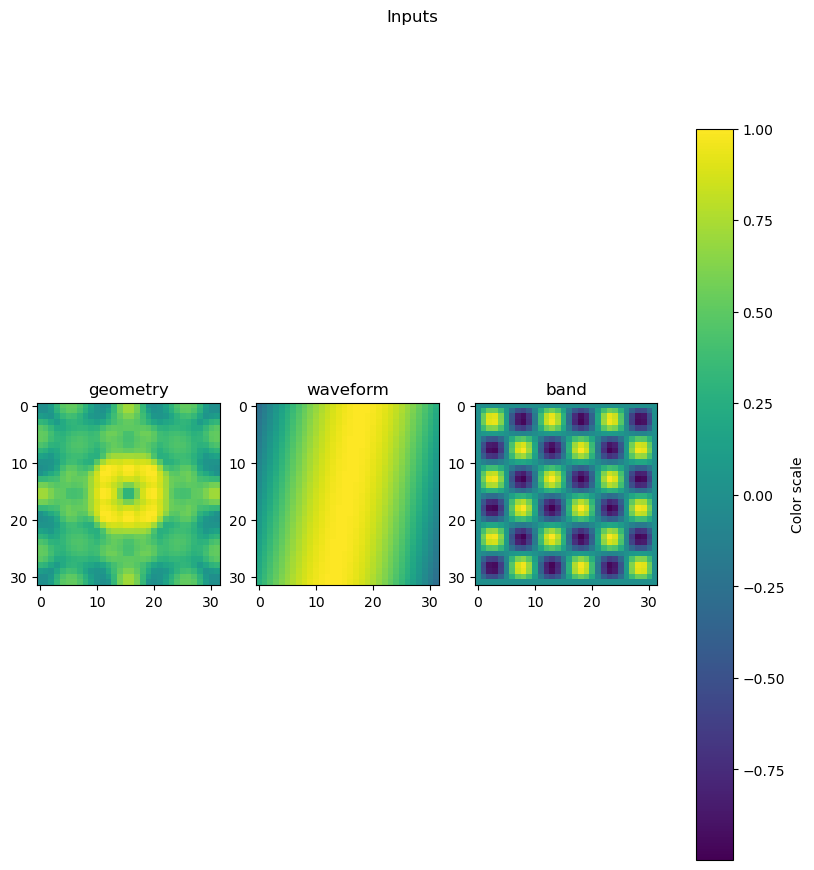

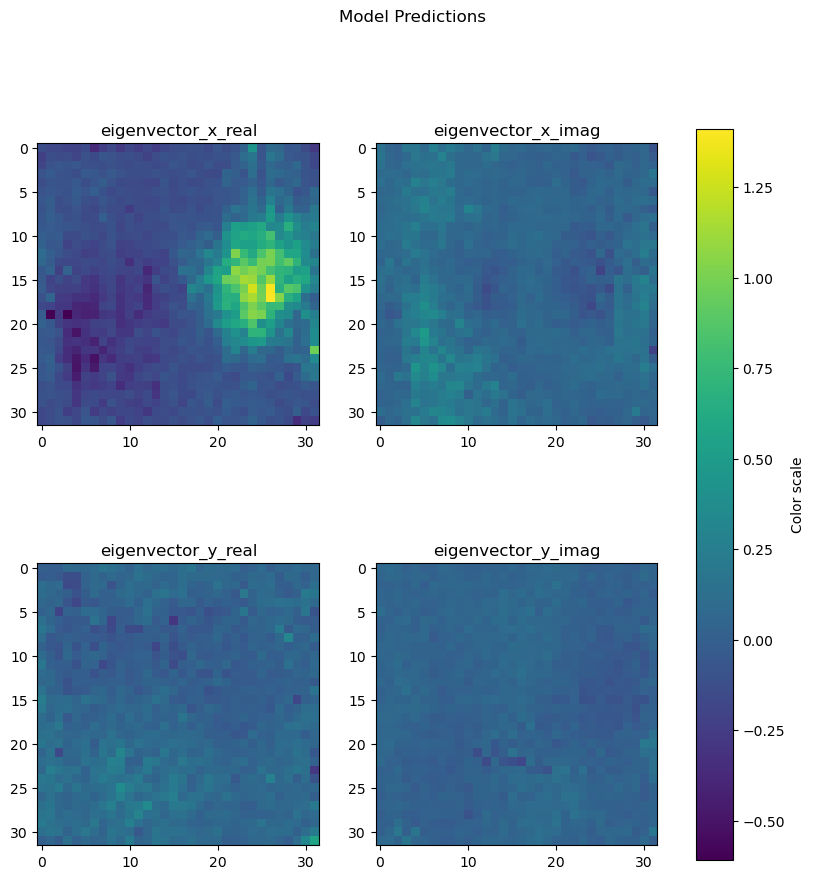

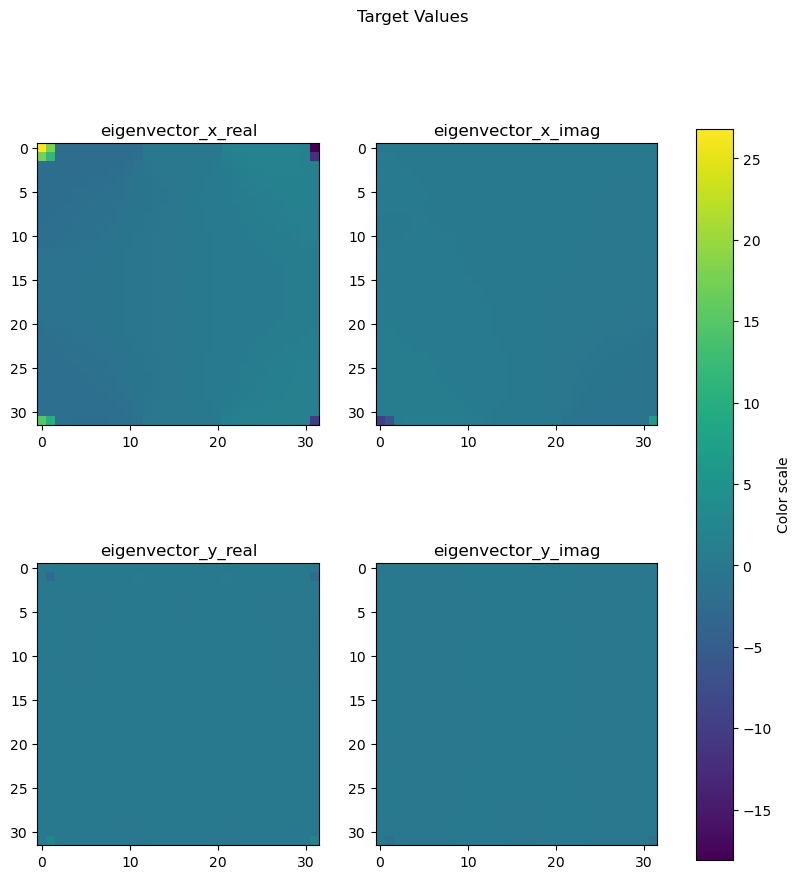

In [56]:
# Get a batch from the validation loader
inputs, targets = next(iter(val_loader))
inputs, targets = inputs.to(device), targets.to(device)

# Get a single sample from the batch
input_sample = inputs[24]
target_sample = targets[24]

# Run the model to get predictions
model.eval()
with torch.no_grad():
    output_sample = model(input_sample.unsqueeze(0)).squeeze(0)

# Plot the inputs, predictions, and targets
plot_predictions_and_targets(input_sample, output_sample, target_sample)
